In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from collections import defaultdict



# plot settings
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 13
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.3
mpl.rcParams["axes.axisbelow"] = True

TEX_PLOTS = False

if TEX_PLOTS:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{palatino}
     \usepackage{newpxmath}""")
else:
    plt.rc("text", usetex=False)
    
plt.rc("font", family="serif")

In [2]:
# data generated by running the following command in this directory:
#  $ ./run_model.py data/time_steps_data.npz --repetitions=75 --n-cores=6 --collect-timeseries=True --time-steps=2000
# which took about 1 hour on my shitty 2016 macbook
data = np.load("data/310122_experiment1_t2000.npz", allow_pickle=True)
dfs = [pd.DataFrame.from_dict(d) for d in data["results"]]
t = len(dfs[0])

In [3]:
n_extinctions = 0
for df in dfs:
    if df["Ant Biomass"].iloc[-1] == 0:
        n_extinctions += 1
print(f"{n_extinctions} out of {len(dfs)} runs went extinct")

66 out of 100 runs went extinct


## Statistical plots

In [4]:
concat_df = pd.concat(dfs)
grouped_df = concat_df.groupby(level=0)
means_df = grouped_df.mean()
std_df = grouped_df.std()

In [5]:
cols = ("Fungus Biomass", "Ant Biomass", "Fraction forager ants", "Dormant caretakers fraction")
colors = ("black", "tab:brown", "tab:red", "tab:green")

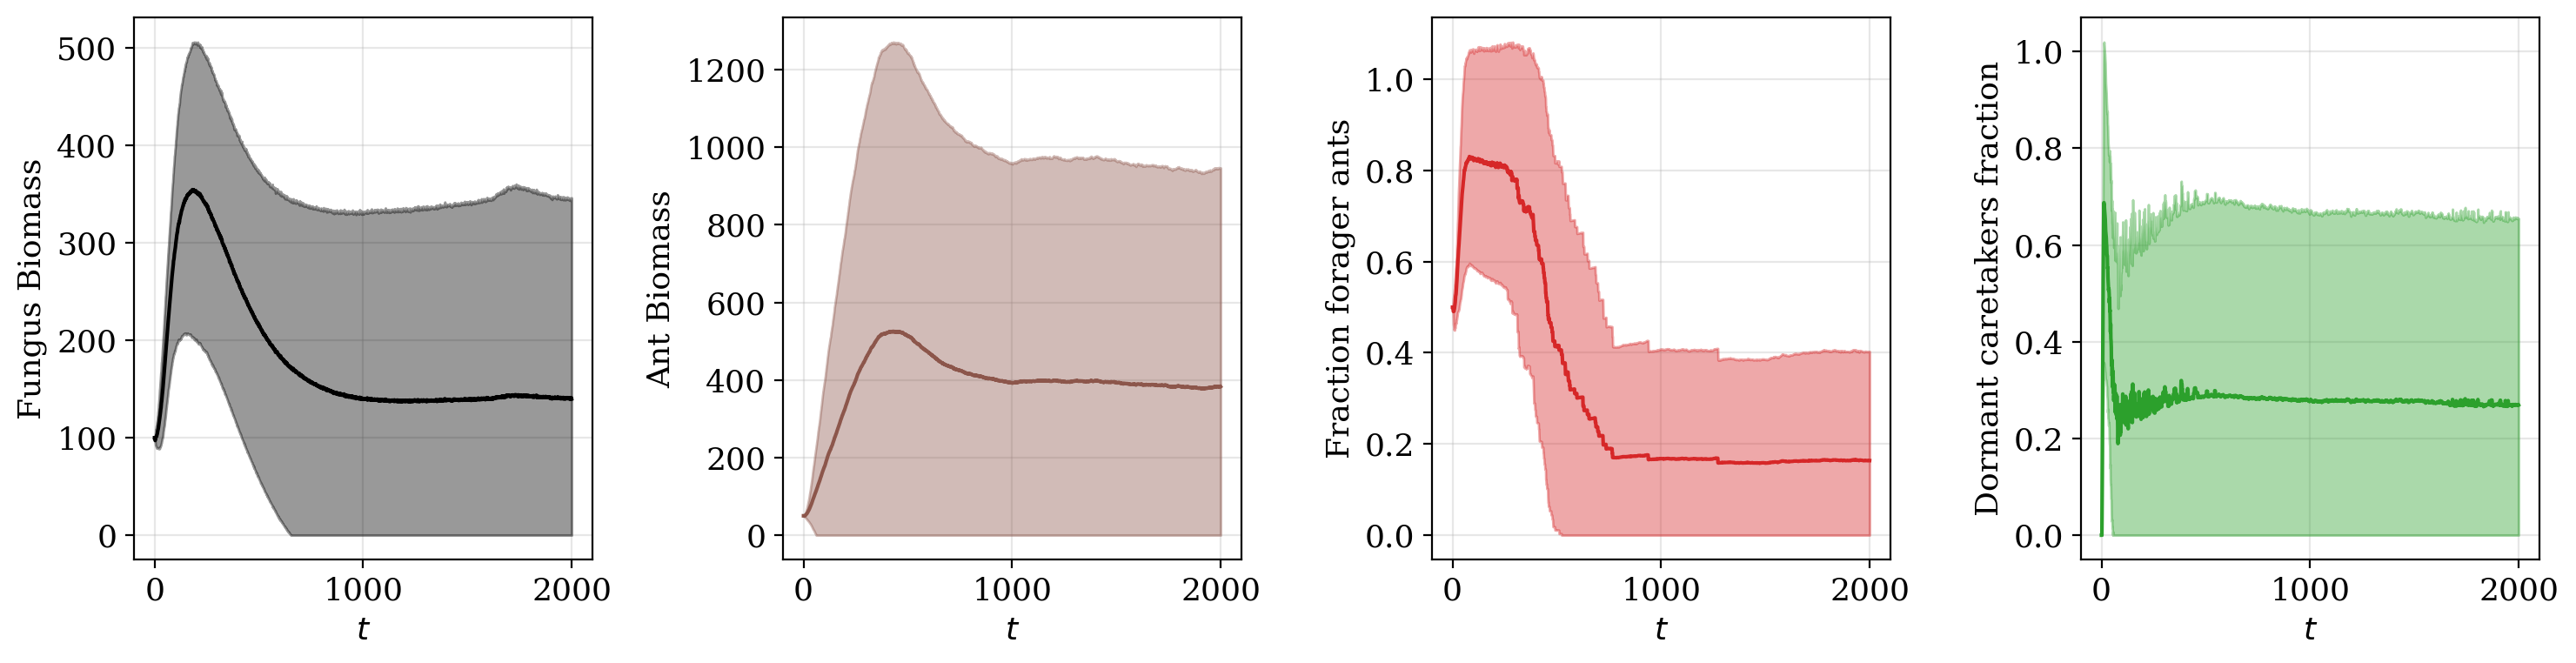

In [6]:
fig = plt.figure(figsize=(15, 4))

for i, (measure, color) in enumerate(zip(cols, colors)):
    ax = fig.add_subplot(1, len(cols), i+1)
    ax.plot(range(t), means_df[measure], label=measure, color=color)
    mean_min_std = means_df[measure] - std_df[measure]
    mean_min_std[mean_min_std < 0] = 0
    
    ax.fill_between(range(t),
                    mean_min_std, means_df[measure] + std_df[measure],
                    alpha=0.4, color=color)
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"{measure}")
    
plt.tight_layout()
plt.show()

In [7]:
final_measures = defaultdict(list)

# some pandas magician might be able to figure out how to do this more beautifully, but I sure am not
for measure in cols:
    for df in dfs:
        final_measures[measure].append(df[measure].iloc[-1])

final_measures_df = pd.DataFrame.from_dict(final_measures)

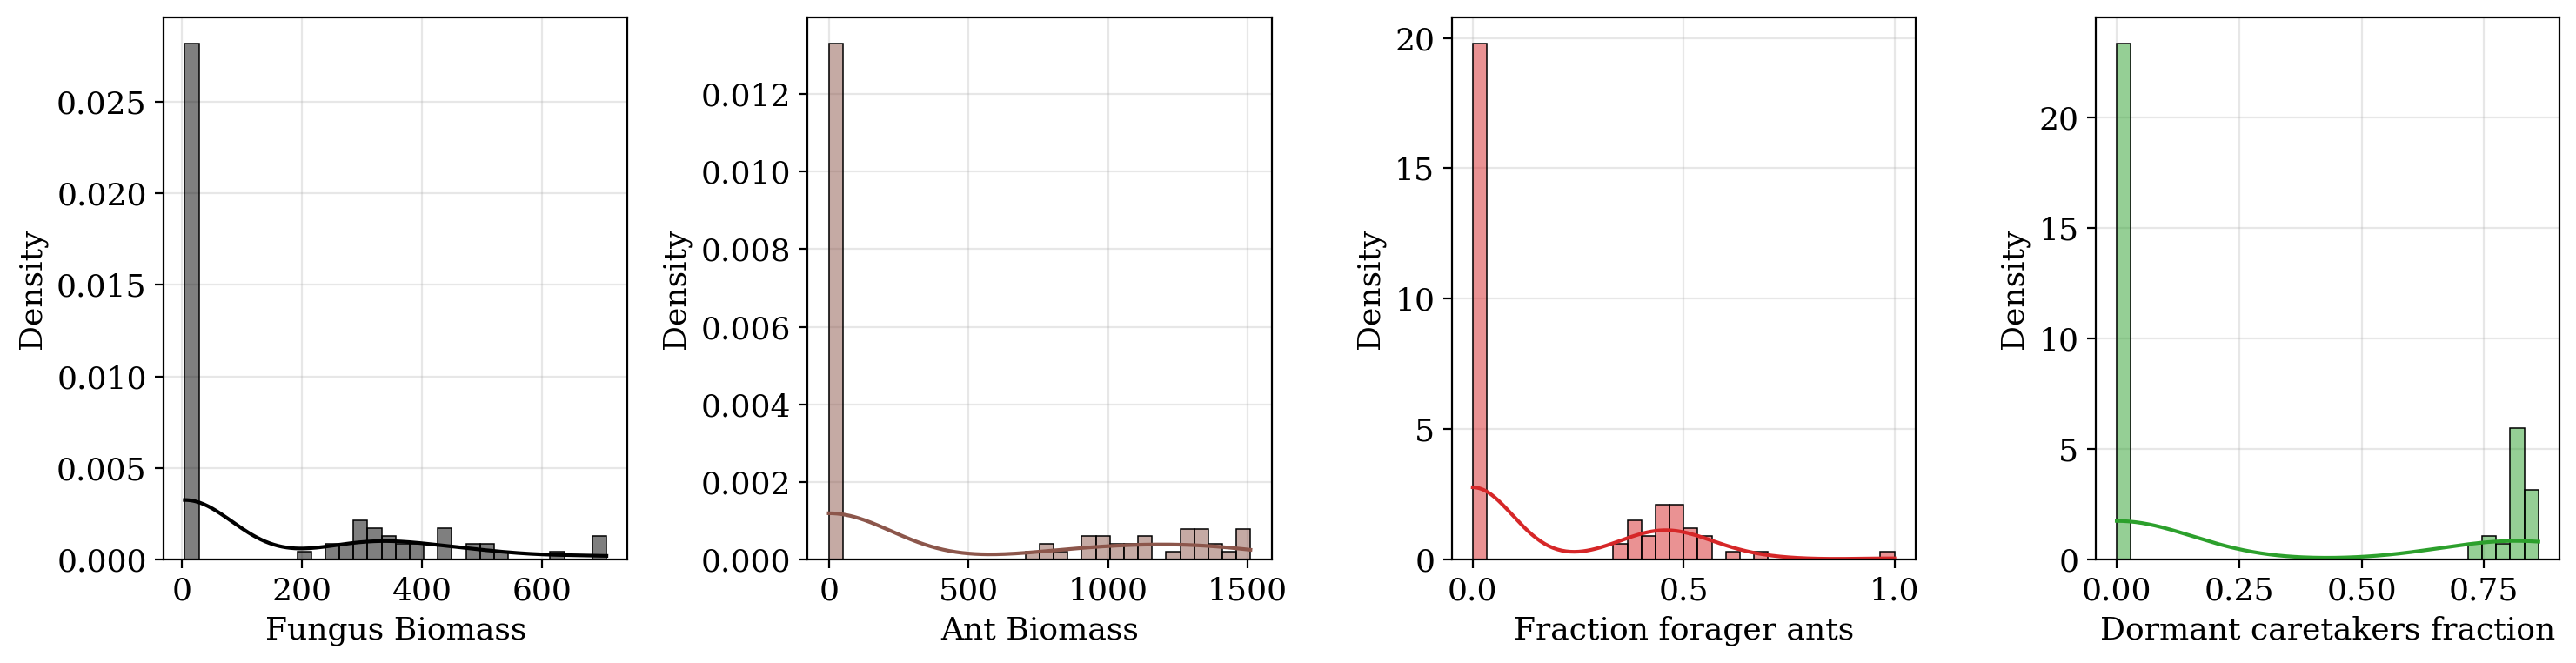

In [8]:
fig = plt.figure(figsize=(15, 4))

for i, (measure, color) in enumerate(zip(cols, colors)):
    ax = fig.add_subplot(1, len(cols), i+1)
    g = sns.histplot(data=final_measures_df, x=measure, alpha=0.5, bins=30, ax=ax, color=color, kde=True, stat="density")
    ax.set_ylabel("Density")
    #ax.set_title(f"Final {measure} Distribution")

plt.tight_layout()
plt.show()

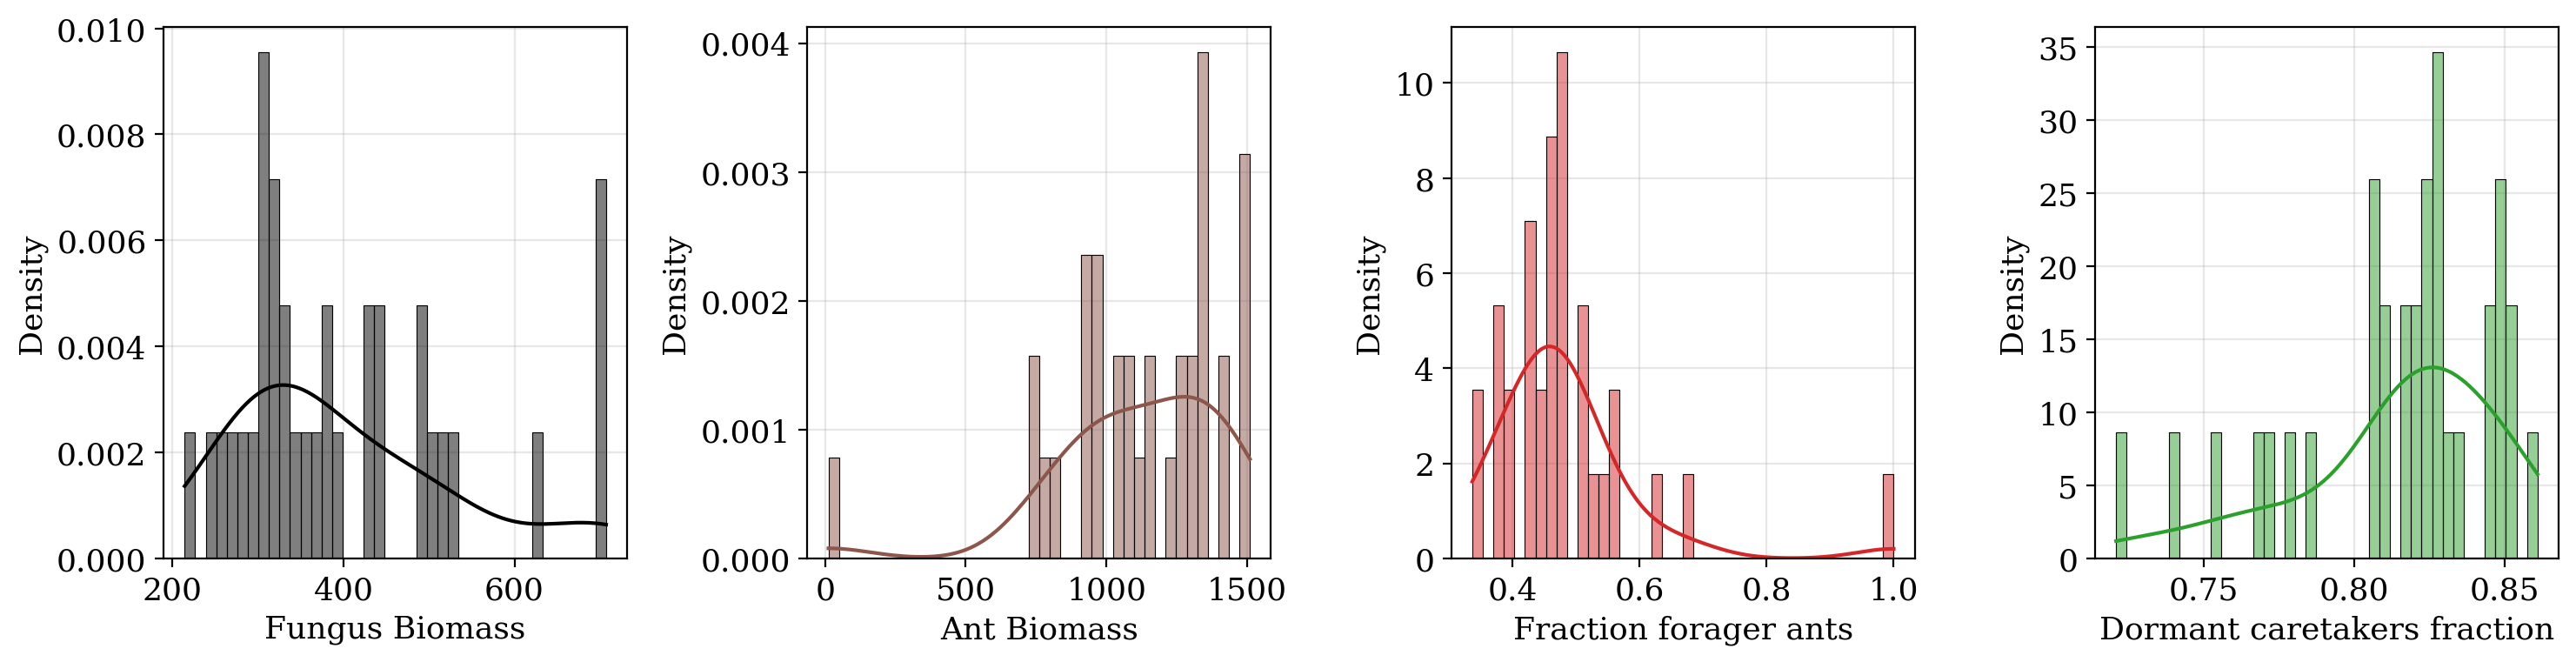

In [9]:
fig = plt.figure(figsize=(15, 4))

final_measures_df_filtered = final_measures_df.copy()

for i, (measure, color) in enumerate(zip(cols, colors)):
    # filter zeros
    if measure == "Fungus Biomass":
        # < 5 is a dead fungus!
        filtered_df = final_measures_df[measure].loc[~(final_measures_df[measure] < 5)]
    else:
        filtered_df = final_measures_df[measure].loc[~(final_measures_df[measure] == 0)]
        
    ax = fig.add_subplot(1, len(cols), i+1)
    g = sns.histplot(data=filtered_df, alpha=0.5, bins=40, ax=ax, color=color, kde=True, stat="density")
    ax.set_ylabel("Density")
    #ax.set_title(f"Final {measure} Distribution")

plt.tight_layout()
plt.show()

## Individual run

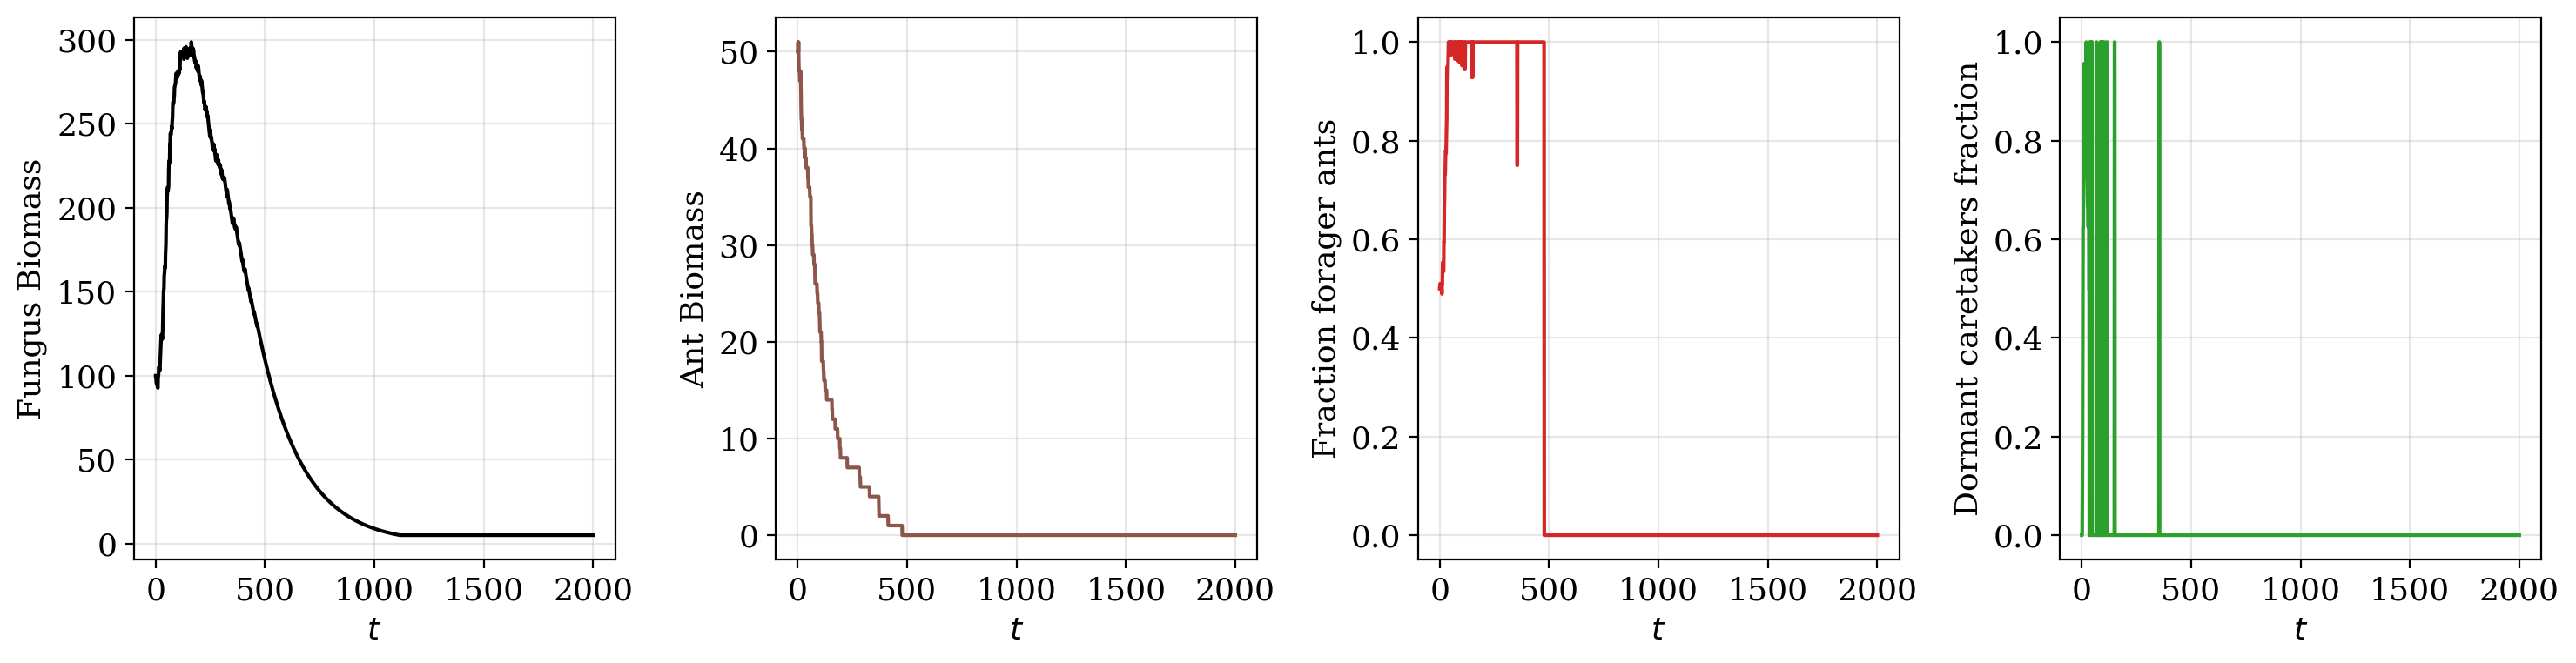

In [10]:
run = 9
fig = plt.figure(figsize=(15, 4))

for i, (measure, color) in enumerate(zip(cols, colors)):
    ax = fig.add_subplot(1, len(cols), i+1)
    ax.plot(range(t), dfs[run][measure], label=measure, color=color)
    ax.set_ylabel(f"{measure}")
    ax.set_xlabel("$t$")
    
plt.tight_layout()
plt.show()

In [11]:
def extinct_at_end_p(df, col="Ant Biomass", val=0):
    return df[col].iloc[-1] == val

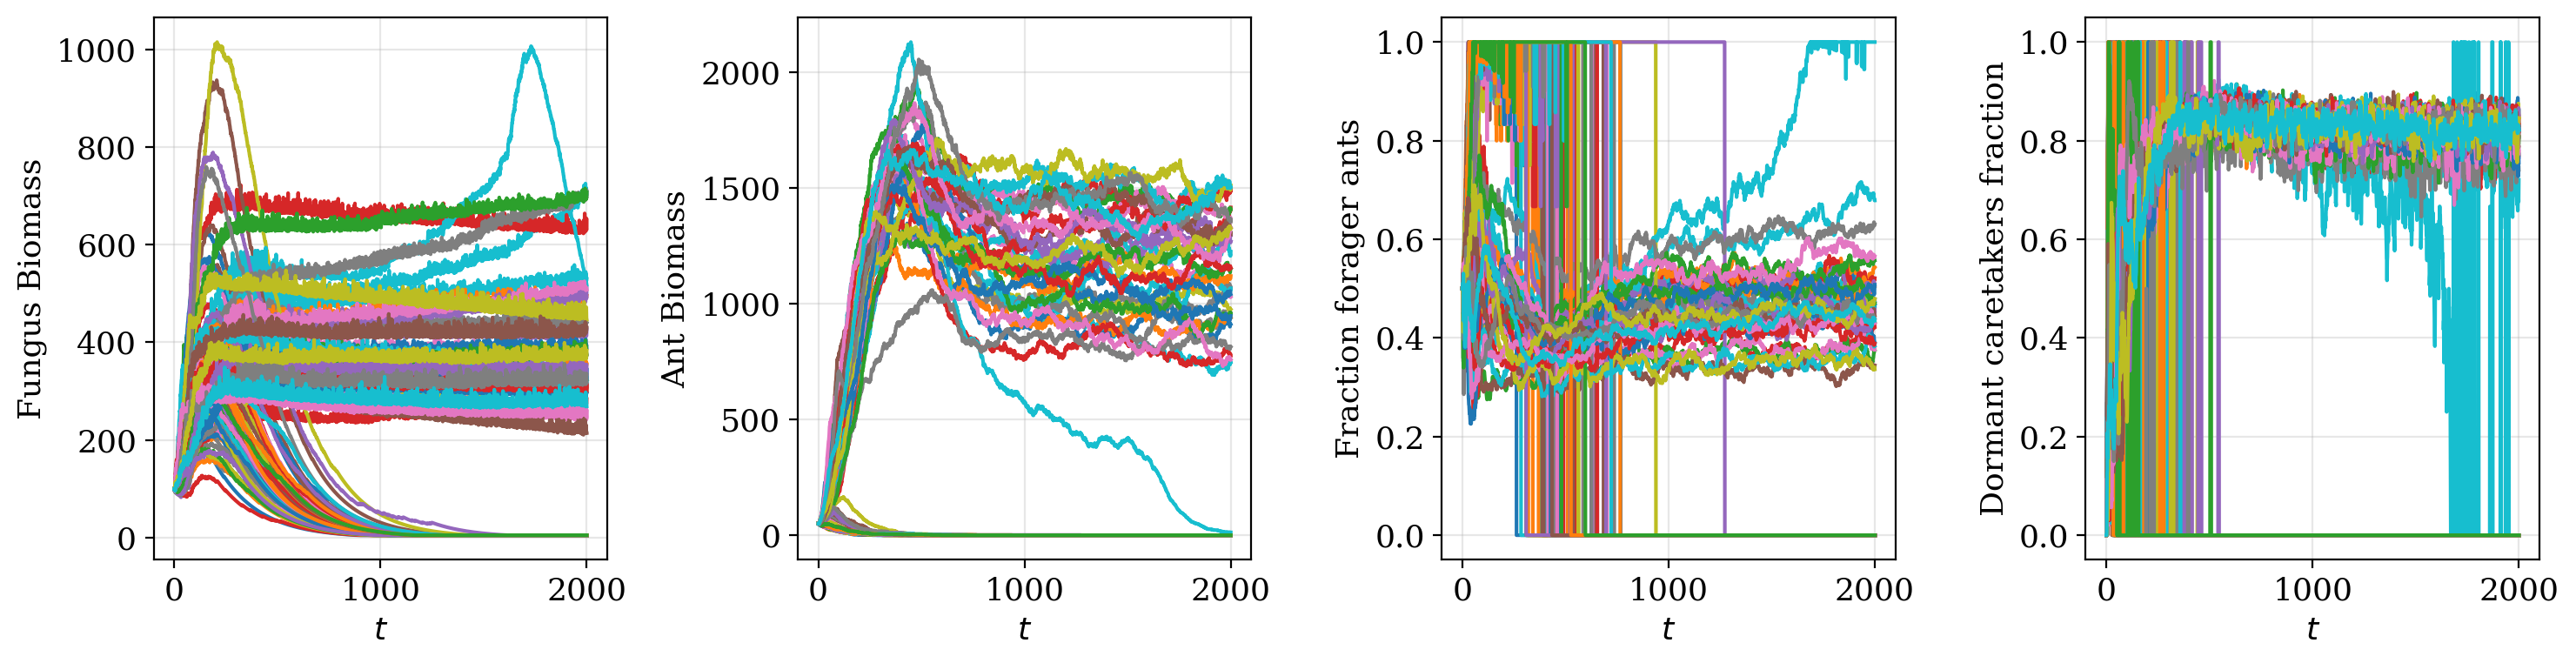

In [15]:
fig = plt.figure(figsize=(15, 4))

for i, measure in enumerate(cols):
    ax = fig.add_subplot(1, len(cols), i+1)
    for df in dfs[:]:
        # filter out extinction runs
#         if not extinct_at_end_p(df):
        ax.plot(range(t), df[measure], label=measure)
    ax.set_ylabel(measure)
    ax.set_xlabel("$t$")
    
plt.tight_layout()
plt.show()

mean: 40.583887065988584, stdev: 30.823354933809753


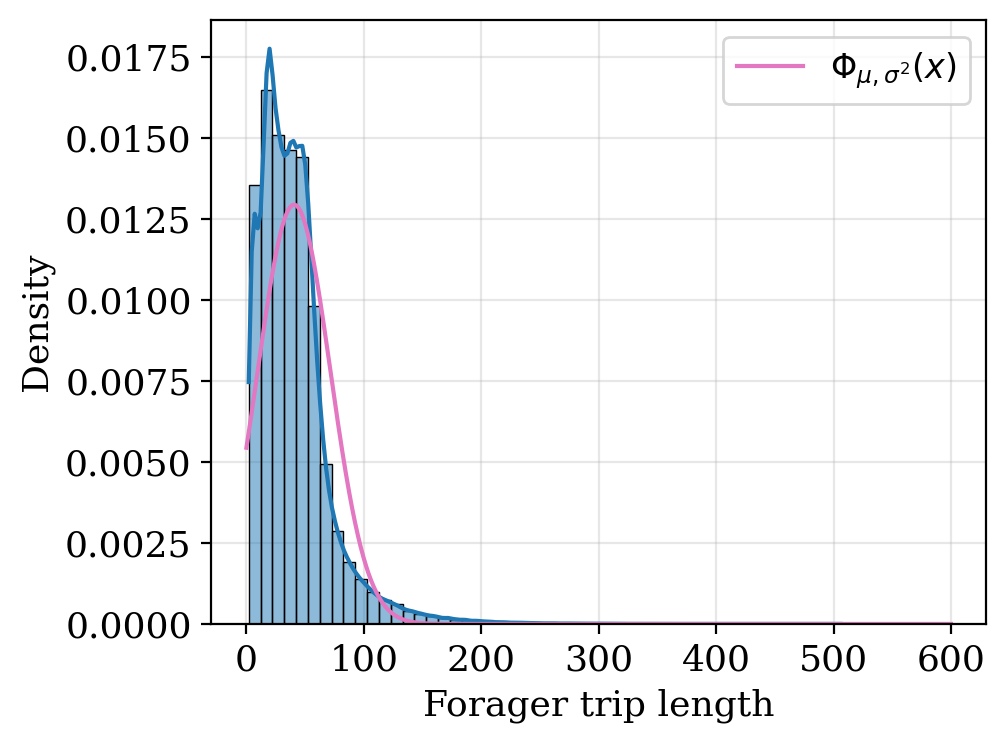

In [13]:
from itertools import chain

def normal_dist(x, mu, sigma):
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x - mu)**2 / (2*sigma**2))

plt.figure(figsize=(5, 4))
trip_durations = np.array(list(chain.from_iterable(data["trip_durations"])))
mean, stdev = np.mean(trip_durations), np.std(trip_durations)
print(f"mean: {mean}, stdev: {stdev}")

sns.histplot(data=trip_durations, alpha=0.5, bins=50, kde=True, stat="density")
x = np.linspace(0, 600, 1000)
plt.plot(x, normal_dist(x, mean, stdev), color="tab:pink", label="$\\Phi_{\\mu, \\sigma^2}(x)$")
plt.ylabel("Density")
plt.xlabel("Forager trip length")
plt.legend()
plt.show()

## Bifurcation Fraction Die

We explore the fraction of colonies that die in early stage, and see whether there may be a bifurcation happening for the initial conditions.

In [16]:
from model import LeafcutterAntsFungiMutualismModel, track_ants, track_leaves, track_ratio_foragers
from model import track_ants_leaves, track_dormant_ants
from batchrunner import BatchRunnerMP
from model.ant_agent import DeathReason

In [15]:
# first lets get the fraction of colonies that die for this data


In [65]:
model = LeafcutterAntsFungiMutualismModel()

max_steps = 1500
repetitions = 30

model_reporters = {"Ants_Biomass": track_ants,
                   "Fungus_Biomass": lambda m: m.fungus.biomass,
                   "Fraction forager ants": track_ratio_foragers,
                   "Fraction forager ants": track_ratio_foragers,
                   "Available leaves": track_leaves,
                   "Dormant caretakers fraction": track_dormant_ants,
                   "Death reason": lambda m: m.death_reason,
}

fixed_parameters = {'collect_data': True,
                         'width': 50,
                         'height': 50,
                         'num_ants': 50,
                         'num_plants': 64, 
                         'pheromone_lifespan': 30,
                         'num_plant_leaves': 100,
                         'initial_foragers_ratio': 0.5, 
                         'leaf_regrowth_rate': 0.5,
                         'ant_death_probability': 0.01,
                         'initial_fungus_energy': 50,
                         'fungus_decay_rate': 0.005, 
                         'energy_biomass_cvn': 2.0, 
                         'fungus_larvae_cvn': 0.9,
                         'energy_per_offspring': 1.0,
                         'fungus_biomass_death_threshold': 5.0,
                         'max_fitness_queue_size': 10,
                         'caretaker_carrying_amount': 1,
                         'caretaker_roundtrip_mean': 5.0, 
                         'caretaker_roundtrip_std': 5.0,
                         'dormant_roundtrip_mean': 60.0,
    }


variable = 'ant_death_probability'

batch = BatchRunnerMP(LeafcutterAntsFungiMutualismModel, nr_processes=8,
                        max_steps=max_steps,
                        iterations=repetitions,
                        model_reporters=model_reporters,
                        display_progress=True,
                        #fixed_parameters=fixed_parameters,
                         variable_parameters= {variable:np.linspace(0.002, 0.015, 6)})

batch.run_all()

data = batch.get_collector_model()

37it [12:38, 20.51s/it] Process ForkPoolWorker-48:
Process ForkPoolWorker-44:
Process ForkPoolWorker-41:
Process ForkPoolWorker-42:
Process ForkPoolWorker-43:
Process ForkPoolWorker-45:
Process ForkPoolWorker-46:
Process ForkPoolWorker-47:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/floor/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/floor/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/floor/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/floor/.local/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/floor/.local/lib/python3.8/site-

KeyboardInterrupt
  File "/home/floor/.local/lib/python3.8/site-packages/mesa/time.py", line 125, in step
    agent.step()

  File "/home/floor/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/floor/.local/lib/python3.8/site-packages/mesa/space.py", line 518, in _place_agent
    if agent not in self.grid[x][y]:
  File "/WIN_D/Shared/Documents/School/Master/AgentBasedModelling/agent-based-modeling-project/leafcutter_ants_fungi_mutualism/model/ant_agent.py", line 66, in step
    self.neighbor_density_acc += self.get_neighborhood_density()


KeyboardInterrupt: 

  File "/home/floor/.local/lib/python3.8/site-packages/multiprocess/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/WIN_D/Shared/Documents/School/Master/AgentBasedModelling/agent-based-modeling-project/leafcutter_ants_fungi_mutualism/model/ant_agent.py", line 271, in get_neighborhood_density
    for agent in self.model.grid.iter_cell_list_contents(cell):
KeyboardInterrupt
  File "/WIN_D/Shared/Documents/School/Master/AgentBasedModelling/agent-based-modeling-project/leafcutter_ants_fungi_mutualism/batchrunner.py", line 85, in _run_wrappermp
    model.step()
  File "/WIN_D/Shared/Documents/School/Master/AgentBasedModelling/agent-based-modeling-project/leafcutter_ants_fungi_mutualism/model/ant_agent.py", line 220, in get_nearby_plants_and_pheromones
    for p in neighbors:
  File "/home/floor/.local/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/home/floor/.loca

In [66]:
variable = 'initial_foragers_ratio'

model_reporters = {"Ants_Biomass": track_ants,
                   "Fungus_Biomass": lambda m: m.fungus.biomass,
                   "Fraction forager ants": track_ratio_foragers,
                   "Fraction forager ants": track_ratio_foragers,
                   "Available leaves": track_leaves,
                   "Dormant caretakers fraction": track_dormant_ants,
                   "Death reason": lambda m: m.death_reason,
}

# data = np.load('data/bifurcation_test_ants.npz', allow_pickle=True)['data'][()]
# snapshot_data = np.load('data/bifurcation_test_ants_snapshot.npz', allow_pickle=True)['arr_0']

snapshot_data = batch.get_model_vars_dataframe()

print(snapshot_data)

cols = ("Fungus Biomass", "Ant Biomass", "Fraction forager ants", "Dormant caretakers fraction", 
        "Available leaves")
colors = ("black", "tab:brown", "tab:red", "tab:green", "tab:orange")


def plot_param_var_conf(ax, df, var, param, i):
    """
    Modified from the Sensitivity Analysis notebook provided by the course Agent-based-modelling
    
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.
    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variables to be taken from the dataframe
        param: which output variable to plot
    """
    print('param',param)
    print('var', var)
    print(type(df))
    print(df.shape)
    x = df.groupby(var).mean().reset_index()[var]
    y = df.groupby(var).mean()[param]
    
    
#     print(df)
    
    repetitions = df.groupby(var)[param].count()
    minimum = df.groupby(var)[param].min()
    maximum = df.groupby(var)[param].max()
    
    stdev = df.groupby(var)[param].std()

    ax.vlines(x, y-stdev, y + stdev, color='grey', alpha = 0.8)
    ax.plot(df[var], df[param], 'ko', markersize=0.8)

    
    ax.scatter(x, y, c='darkgreen', marker='o')
#     ax.plot(x, y, c='k', marker='o', linewidth = 0.8)
#     ax.fill_between(x, y - stdev, y + stdev, color='grey', alpha=0.2)
    
    
    
#     ax.plot(x, minimum, c='magenta', marker='x', linewidth = 0.8)
#     ax.plot(x, maximum, c='deepskyblue', marker='+', linewidth = 0.8)
    ax.scatter(x, minimum, c='magenta', marker='x')
    ax.scatter(x, maximum, c='deepskyblue', marker='+')

    ax.set_xlabel(var)
    ax.set_ylabel(param)
    # ax.grid()

    ax.tick_params(which='both', labelsize=12)

def plot_all_vars(data, model_reporters, save_fig=False, show_fig=True):
    """
    Modified from the Sensitivity Analysis notebook provided by the course Agent-based-modelling

    Uses plot_param_var_conf to plot the OFAT results provided in data on separate axes
    """

    fig, axs = plt.subplots(1,len(model_reporters), figsize=(5*len(model_reporters), 5),
                            constrained_layout=True
                            )

#     for row, var in enumerate(data.keys()):
#         for col, output_param in enumerate(model_reporters):
#             plot_param_var_conf(axs[row,col], data[var], var, output_param, col)
    var = variable
    for col, output_param in enumerate(model_reporters):
#         print(output_param)
        if output_param == 'Death reason':
#             print(output_param)
            x = snapshot_data.groupby(var).mean().reset_index()[var]
#             print(x)
            y = snapshot_data.groupby(var).count()['Death reason']
#             print(y)
            axs[col].scatter(x, y, c='darkgreen', marker='o')
            
        else:
            plot_param_var_conf(axs[col], data, var, output_param, col)
    
    if save_fig:
        fig.savefig(f'figures/bifurcation_test_{variable}' + '.pdf', bbox_inches='tight')

    if show_fig:
        plt.show()


plot_all_vars(snapshot_data, model_reporters, save_fig=False)

# n_extinctions = 0
# for df in dfs:
#     if df["Ant Biomass"].iloc[-1] == 0:
#         n_extinctions += 1
# print(f"{n_extinctions} out of {len(dfs)} runs went extinct")


# fig = plt.figure(figsize=(15, 4))

# for j, val in enumerate(np.linspace(30, 200, 6, dtype=int)):
#     df = data
    
#     for i, measure in enumerate(model_reporters.keys()):
#         ax = fig.add_subplot(1, len(model_reporters.keys()), i+1)
#         for df in dfs[:]:
#             # filter out extinction runs
#     #         if not extinct_at_end_p(df):
#             ax.plot(range(t), df[measure], label=measure)
#         ax.set_ylabel(measure)
#         ax.set_xlabel("$t$")
    
# plt.tight_layout()
# plt.show()

KeyError: "None of [Index(['ant_death_probability', 'Run'], dtype='object')] are in the [columns]"

In [61]:
print(snapshot_data.groupby(variable).count()['Death reason'])

# for i, run in enumerate(snapshot_data['Death reason']):
    
    
    
#     if run == None:
#         snapshot_data['Death_reason_numerical'].iloc[i] = 0
#     elif run == DeathReason.ANTS:

#         snapshot_data['Death_reason_numerical'].iloc[i] = 1
#     elif run == DeathReason.FUNGUS:
#         snapshot_data['Death_reason_numerical'].iloc[i] = 2

# print(snapshot_data[snapshot_data['Death_reason_numerical'] == 1])
        
# fraction of colonies that survive
print(36+23+11+3+4+1)

initial_foragers_ratio
0.10    22
0.28    20
0.46    15
0.64    18
0.82    24
1.00    27
Name: Death reason, dtype: int64
78


In [62]:
# snapshot_data = batch.get_model_vars_dataframe()

# np.savez('data/bifurcation_test_ants', data=data, model_reporters=list(model_reporters.keys()))
# np.savez('data/bifurcation_test_ants_snapshot', snapshot_data)

In [63]:
n_extinctions = 0
# print(snapshot_data["Ants_Biomass"])

for ant in snapshot_data["Ants_Biomass"]:
    if ant == 0:
        n_extinctions += 1
print(f"{n_extinctions} out of {len(snapshot_data)} runs went extinct")

126 out of 180 runs went extinct


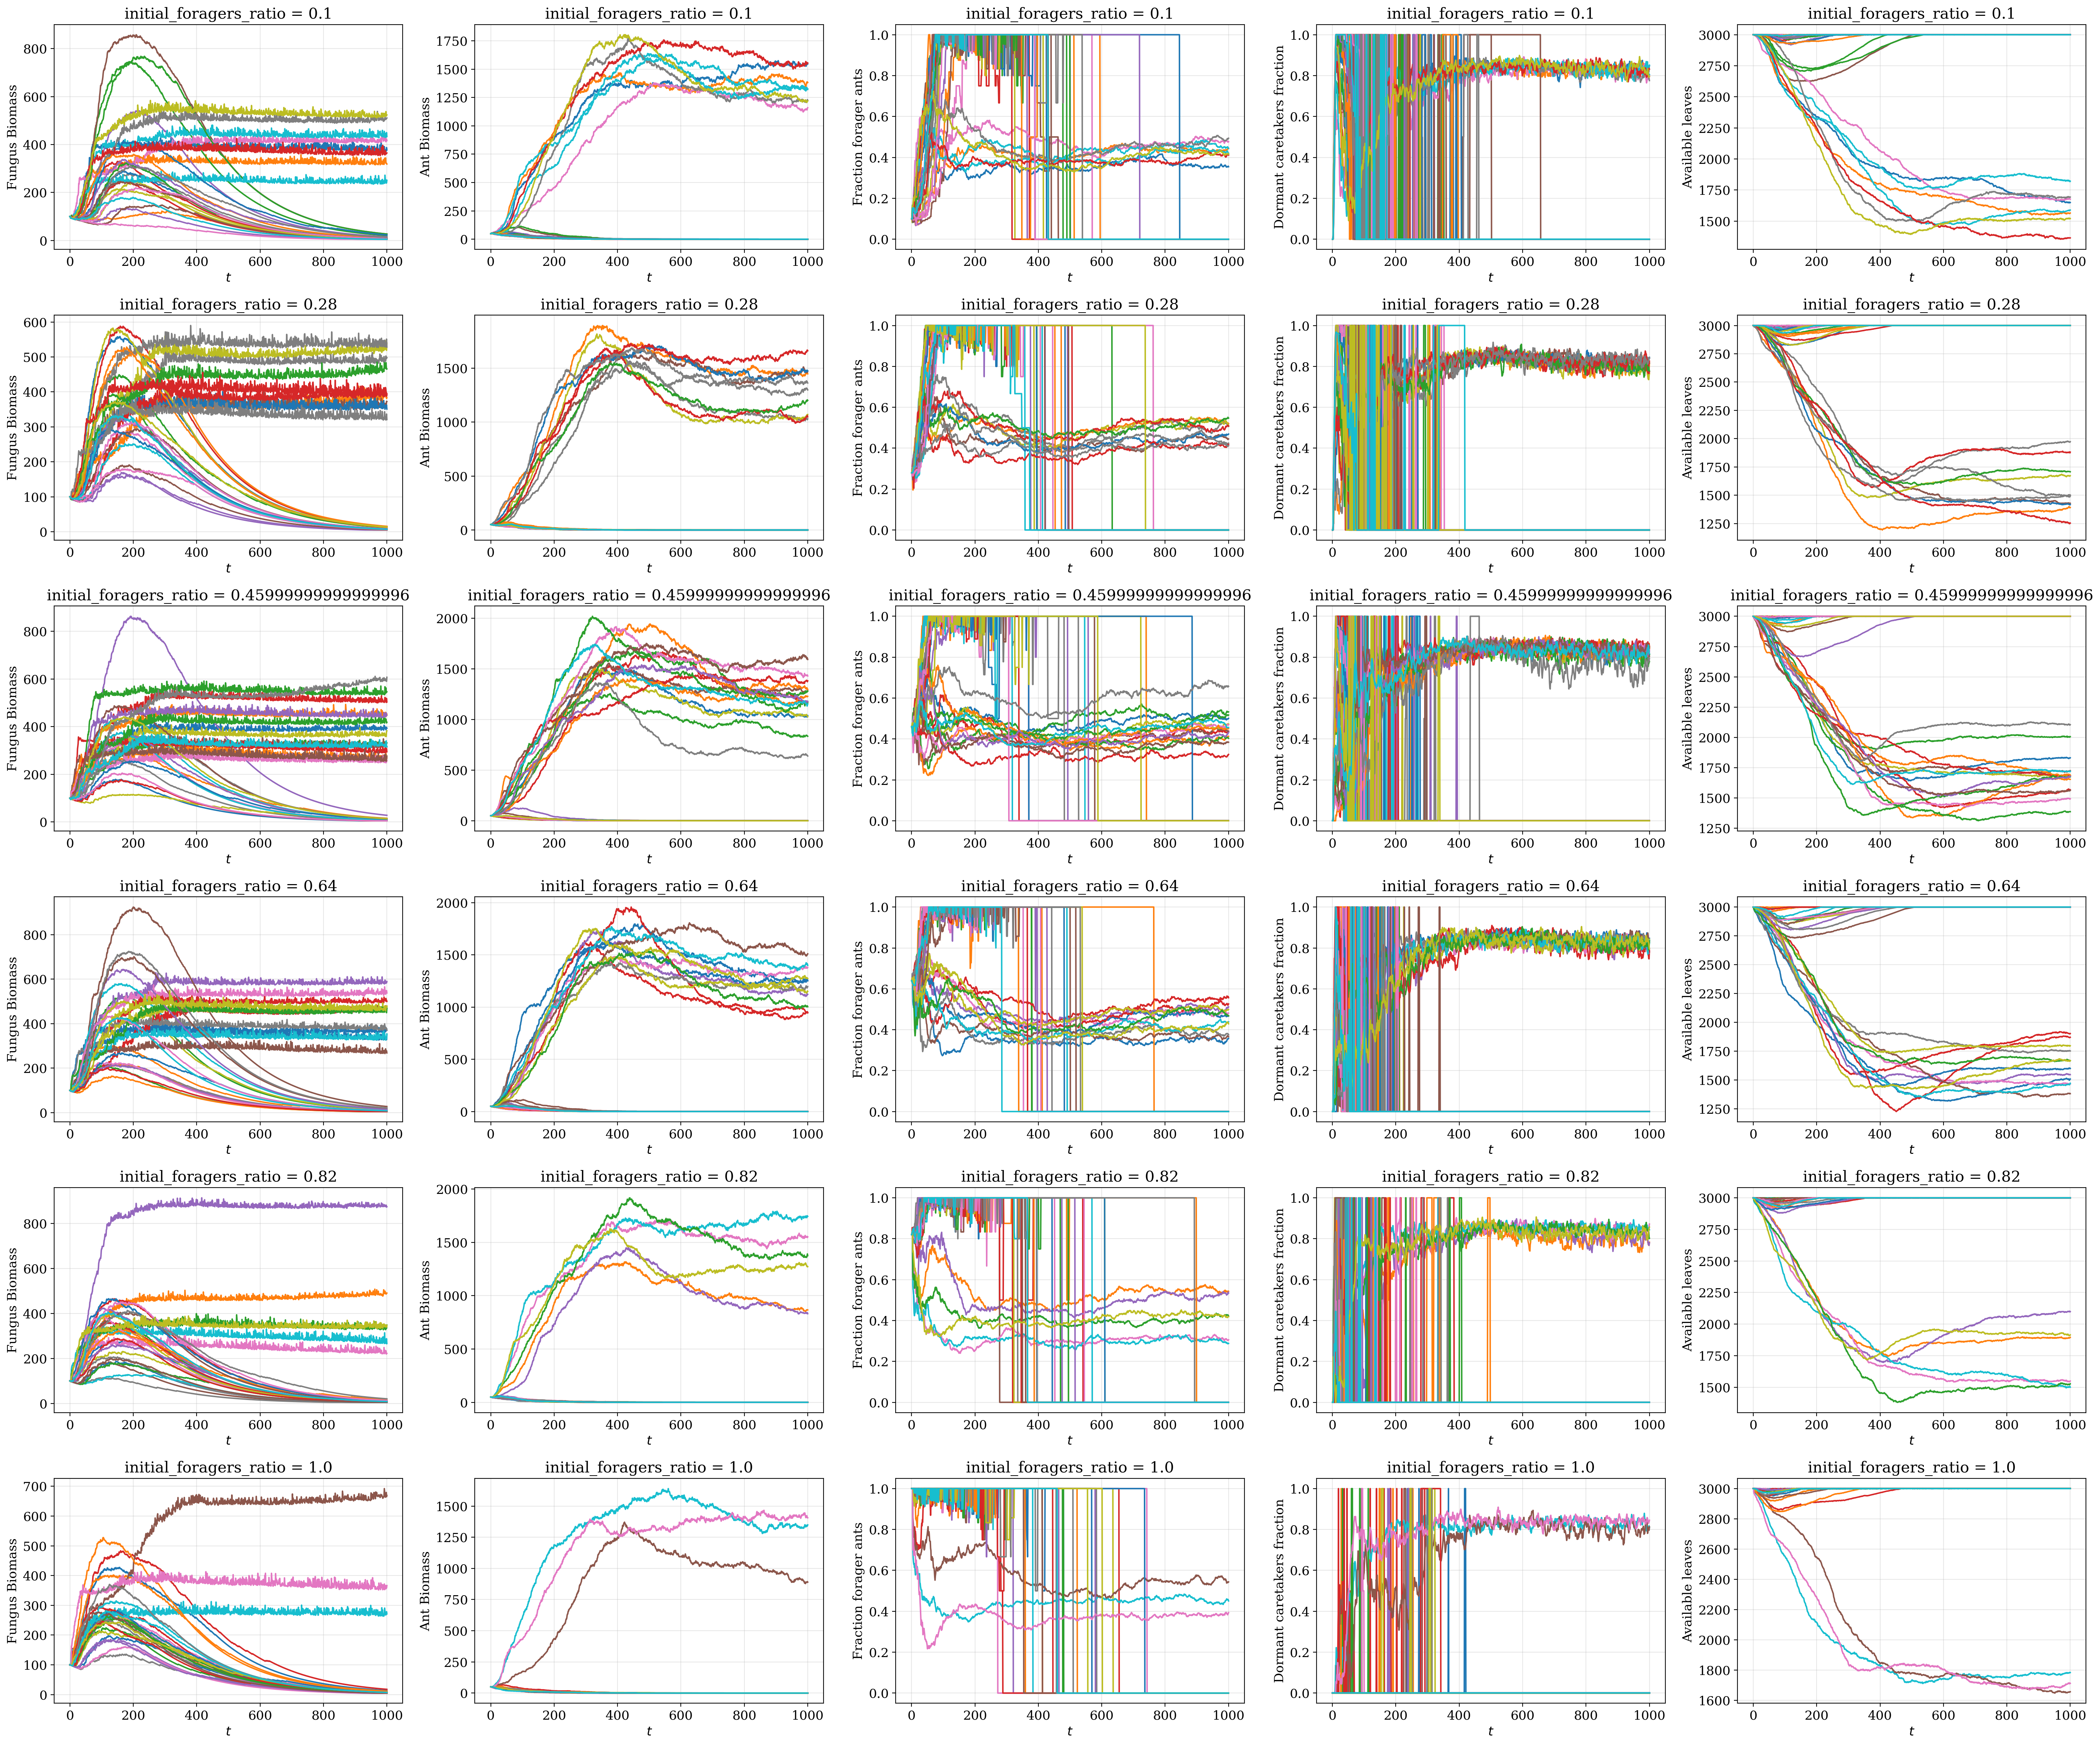

In [64]:
# print(data[(30,2)])

cols = ("Fungus Biomass", "Ant Biomass", "Fraction forager ants", "Dormant caretakers fraction", 
        "Available leaves")
colors = ("black", "tab:brown", "tab:red", "tab:green", "tab:orange")

fig, axs = plt.subplots(6, 5, figsize=(30, 25))

x = snapshot_data.groupby(variable).mean().reset_index()[variable]

for j, value in enumerate(x):
    for run in range(repetitions):
        for i, measure in enumerate(cols):
            df = data[(value, run)]
            axs[j,i].plot(range(max_steps+1), df[measure], label=measure)
            
            axs[j,i].set_ylabel(measure)
            axs[j,i].set_xlabel("$t$")
            axs[j,i].set_title(f'{variable} = {value}')

plt.tight_layout()

fig.savefig(f'figures/bifurcation_allruns_{variable}.pdf', bbox_inches='tight')


plt.show()


# fig = plt.figure(figsize=(15, 4))

# for i, measure in enumerate(cols):
#     ax = fig.add_subplot(1, len(cols), i+1)
#     for df in dfs[:]:
#         # filter out extinction runs
#         if not extinct_at_end_p(df):
#             ax.plot(range(t), df[measure], label=measure)
#     ax.set_ylabel(measure)
#     ax.set_xlabel("$t$")
    
# plt.tight_layout()
# plt.show()

